# Обзор датасета **T1**.

In [1]:
!pip install pandas numpy h5py scikit-learn xgboost matplotlib seaborn

**Загружаем все нужные библиотеки**

In [2]:
import pandas as pd
import numpy as np
import h5py
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb   
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR

In [15]:
!pip install tabulate

## 1. Загрузка и объединение

In [3]:
def load_hdf5_data(hdf5_path, part_id, params):
    """Загрузка данных из HDF5 файла и объединение с параметрами"""
    with h5py.File(hdf5_path, 'r') as f:
        data0 = pd.DataFrame(f['data0'][:])
        features = pd.DataFrame(f['features'][:])
    
    # Удаляем дублирующиеся столбцы
    features = features.drop(columns=['process_status', 'speed'], errors='ignore')
    
    # Объединяем данные
    merged_data = pd.merge(data0, features, left_index=True, right_index=True)
    
    # Добавляем параметры процесса
    process_params = params.loc[params['ID'] == part_id].iloc[0]
    merged_data['Power'] = process_params['Power [W]']
    merged_data['Speed'] = process_params['Speed [mm/s]']
    merged_data['Strategy'] = process_params['Strategy']
    merged_data['part_id'] = part_id
    
    return merged_data

In [4]:
params = pd.read_csv('Testing/Testing/parameters.csv')

In [5]:
datasets = []

T1 = 'T1/T1/T1_P08_v8_PP1_1_s.hdf5'
T2 = 'T2/T2_P08_v8_PP1_2_s.hdf5'
T5 = 'T5/T5_P08_v8_PP2_1_s.hdf5'
T6 = 'T6/T6_P08_v8_PP2_2_s.hdf5'
T26 = 'T26/T26_P08_V8_PP3_1_s.hdf5'
T27 = 'T27/T27_P08_V8_PP3_2_s.hdf5'
for part_id, path in [('T1', T1), ('T2', T2), ('T5', T5), ('T6', T6), ('T26', T26), ('T27', T27)]:
    df = load_hdf5_data(path, part_id, params)
    df['part_id'] = part_id
    datasets.append(df)

## 2. Предобработка данных

In [7]:
def calculate_custom_features(df, n_positions=3):
    """Расчет кастомных признаков по предложенной методике"""
    # 1. Временные промежутки
    df['time_diff'] = df.groupby('part_id')['timestamp'].diff().fillna(0)
    
    # 2. Время работы и простоя лазера
    df['t_laserON'] = df['time_diff'] * df['process_status']
    df['t_laserOFF'] = df['time_diff'] * (1 - df['process_status'])
    
    # 3. Движение лазера (сумма модулей изменений координат)
    for coord in ['x', 'y', 'z']:
        df[f'delta_{coord}'] = df.groupby('part_id')[coord].diff().abs().fillna(0)
    
    df['movement_sum'] = df.groupby('part_id')[['delta_x', 'delta_y', 'delta_z']]\
                          .rolling(n_positions).sum().sum(axis=1).reset_index(level=0, drop=True)
    
    # 4. Накопленные эффекты
    df['cumulative_energy'] = df.groupby('part_id')['t_laserON'].cumsum()
    df['cumulative_cooling'] = df.groupby('part_id')['t_laserOFF'].cumsum()
    
    # 5. Взаимодействие стратегии и движения
    df['strategy_movement'] = df['Strategy'] * df['movement_sum']
    
    # 6. Дополнительные физические параметры
    df['energy_input'] = df['Power'] * df['t_laserON']
    df['cooling_rate'] = df['meltpool_mean'].diff() / (df['t_laserOFF'] + 1e-6)
    
    return df.dropna()

In [8]:
full_data = pd.concat(datasets).reset_index(drop=True)

print(full_data.sample(10))
full_data = calculate_custom_features(full_data)

        carrier_gas_sensor  powder_flow  powder_turntable  process_status  \
209767                 0.0          0.0               0.0             0.0   
716280                 0.0          0.0               0.0             0.0   
371770                 0.0          0.0               0.0             1.0   
393926                 0.0          0.0               0.0             1.0   
436935                 0.0          0.0               0.0             1.0   
595729                 0.0          0.0               0.0             0.0   
682288                 0.0          0.0               0.0             1.0   
271870                 0.0          0.0               0.0             1.0   
170001                 0.0          0.0               0.0             1.0   
421479                 0.0          0.0               0.0             1.0   

              q1        q2        q3        q4     speed    table_roll  ...  \
209767  0.708144  0.005731  0.706020  0.005897  0.000000  8.999999e+09  .

In [8]:
print(full_data.columns)

Index(['carrier_gas_sensor', 'powder_flow', 'powder_turntable',
       'process_status', 'q1', 'q2', 'q3', 'q4', 'speed', 'table_roll',
       'table_yaw', 'thermocoupleA2', 'thermocoupleA3', 'thermocoupleA5',
       'thermocoupleA6', 'thermocoupleA8', 'x', 'y', 'z', 'timestamp',
       'idx_image_data0', 'meltpool_area', 'meltpool_gradient',
       'meltpool_length', 'meltpool_max', 'meltpool_mean', 'meltpool_min',
       'meltpool_ratio', 'meltpool_std', 'meltpool_width', 'Power', 'Speed',
       'Strategy', 'part_id', 'time_diff', 't_laserON', 't_laserOFF',
       'delta_x', 'delta_y', 'delta_z', 'movement_sum', 'cumulative_energy',
       'cumulative_cooling', 'strategy_movement', 'energy_input',
       'cooling_rate'],
      dtype='object')


In [9]:
print(full_data['meltpool_mean'].sample())

172636    75.29287
Name: meltpool_mean, dtype: float64


## 3. Определение признаков и целевой переменной

In [9]:
base_features = ['Power', 'Speed', 'Strategy']
physics_features = [
    'energy_input', 't_laserON', 't_laserOFF',
    'strategy_movement', 'cumulative_cooling', 'cumulative_energy',
    'cooling_rate', 'movement_sum'
]

features = base_features + physics_features

target = 'meltpool_mean'


## 4. Подбор гиперпараметров

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Лучший RMSE: 23.17°C


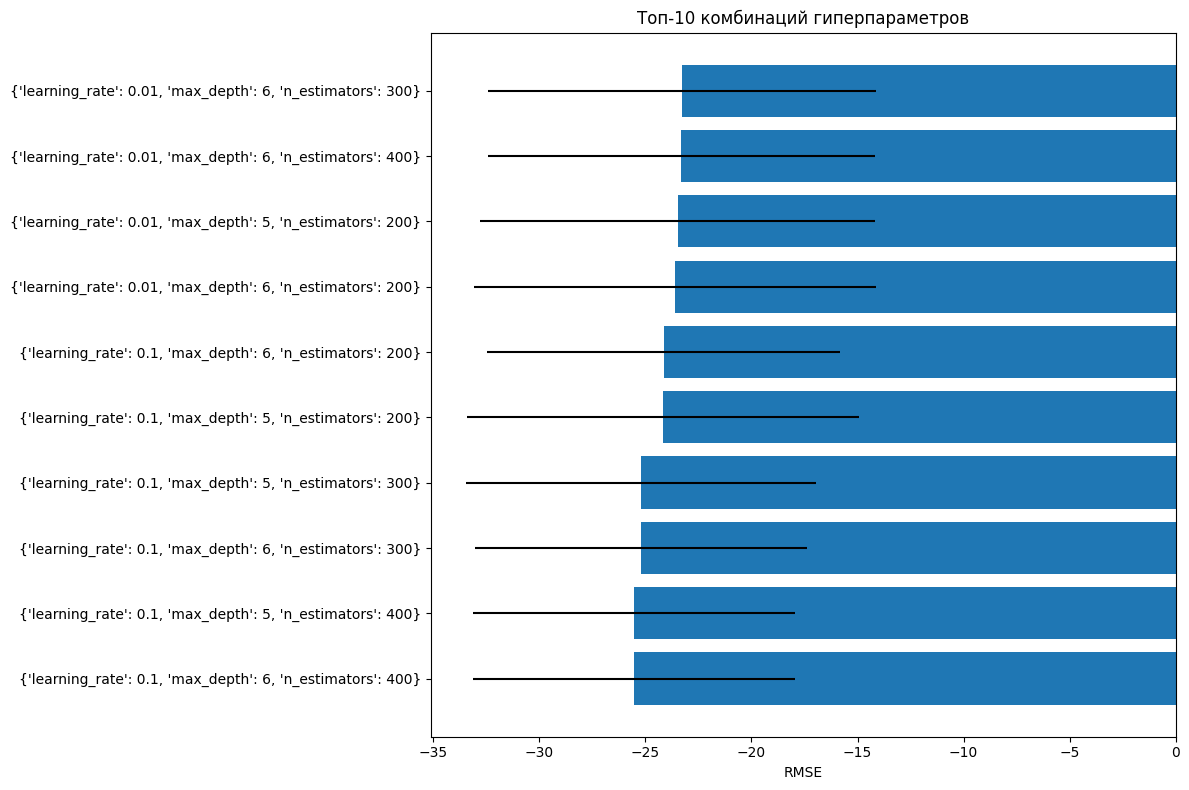

In [10]:
X = full_data[features]
y = full_data[target]

# Создаем кастомную кросс-валидацию для временных рядов
tscv = TimeSeriesSplit(n_splits=5)

# Определяем сетку параметров
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 6],
    'learning_rate': [0.01, 0.1],
}

# Создаем модель и scorer
model = xgb.XGBRegressor(random_state=42, tree_method='hist')
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse_score, greater_is_better=False)

# Настраиваем GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,
    cv=tscv,
    verbose=3,
    n_jobs=-1
)

# Запускаем подбор параметров
grid_search.fit(X, y)

# Выводим результаты
print("Лучшие параметры:", grid_search.best_params_)
print(f"Лучший RMSE: {abs(grid_search.best_score_):.2f}°C")

# Визуализация результатов
results = pd.DataFrame(grid_search.cv_results_)
top_results = results.sort_values('mean_test_score', ascending=True).head(10)

plt.figure(figsize=(12, 8))
plt.barh(
    top_results['params'].astype(str),
    top_results['mean_test_score'],
    xerr=top_results['std_test_score']
)
plt.xlabel('RMSE')
plt.title('Топ-10 комбинаций гиперпараметров')
plt.tight_layout()
plt.show()

## 5. Обучение модели

In [27]:
X = full_data[features]
y = full_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

base_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    random_state=42,
    eval_metric='mae'
)

physics_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    random_state=42,
    eval_metric='mae'
)

# Обучение и оценка базовой модели
print("Обучение модели с базовыми признаками...")
base_model.fit(X_train[base_features], y_train)
y_pred_base = base_model.predict(X_test[base_features])

# Обучение и оценка модели с физическими фичами
print("Обучение модели с физическими признаками...")
physics_model.fit(X_train[features], y_train)
y_pred_physics = physics_model.predict(X_test[features])

Обучение модели с базовыми признаками...
Обучение модели с физическими признаками...


## 7. Резульаты

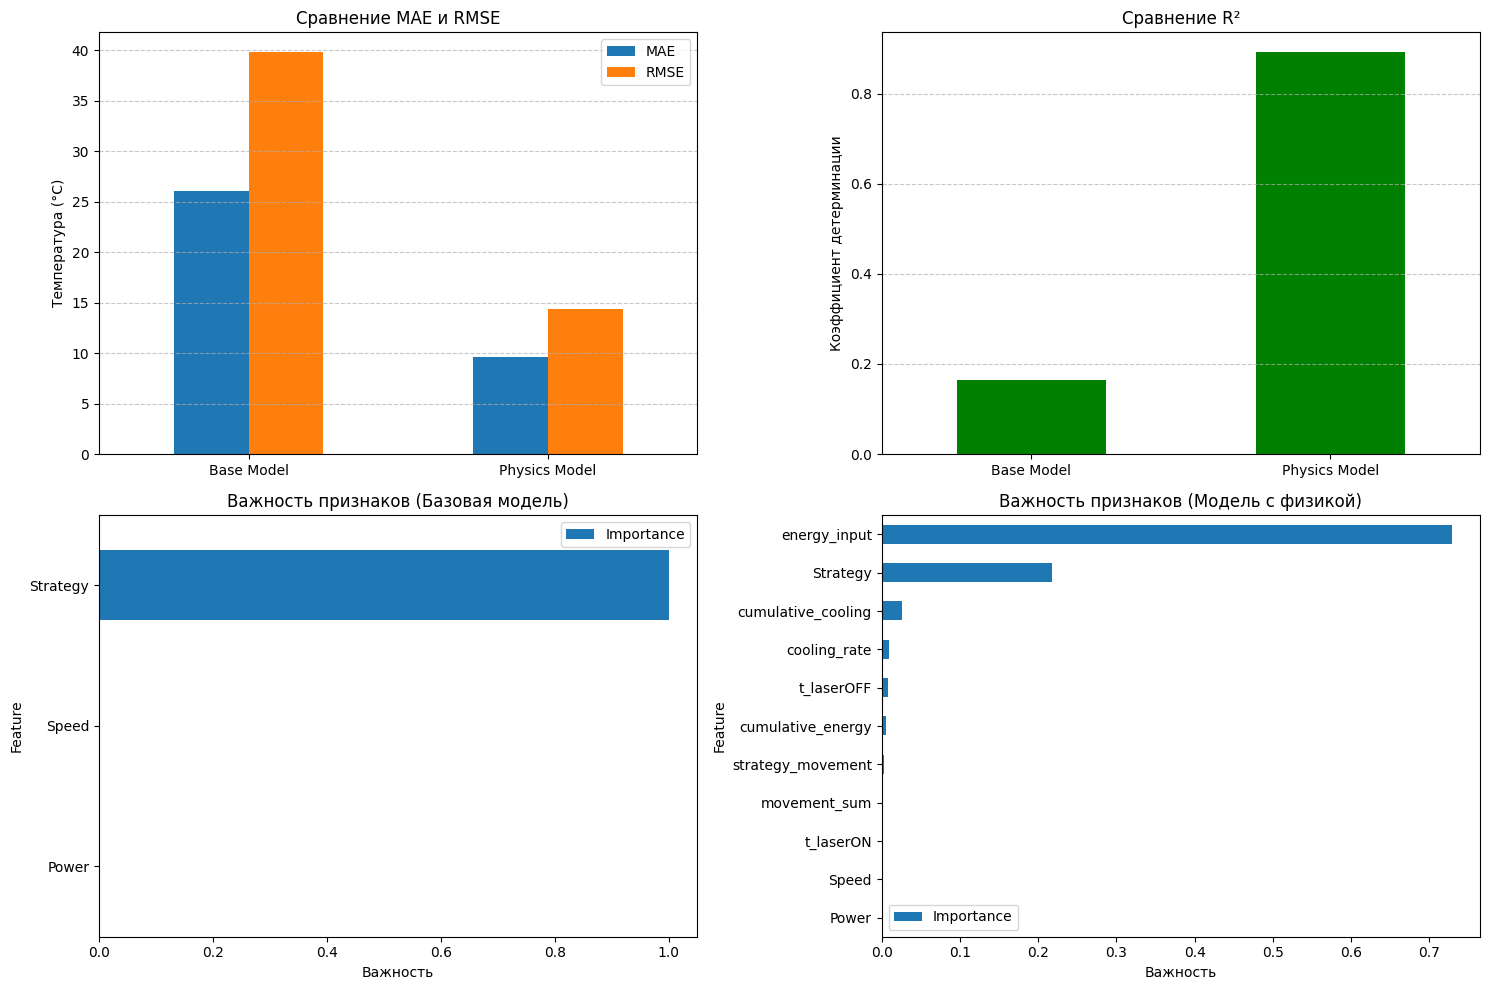


=== Сравнение моделей XGBoost ===
|      |   Base Model |   Physics Model |
|:-----|-------------:|----------------:|
| MAE  |       26.023 |           9.599 |
| RMSE |       39.784 |          14.327 |
| R2   |        0.165 |           0.892 |

=== Улучшение метрик ===
| Metric   |   Improvement (%) |
|:---------|------------------:|
| MAE      |              63.1 |
| RMSE     |              64   |
| R2       |             439.5 |


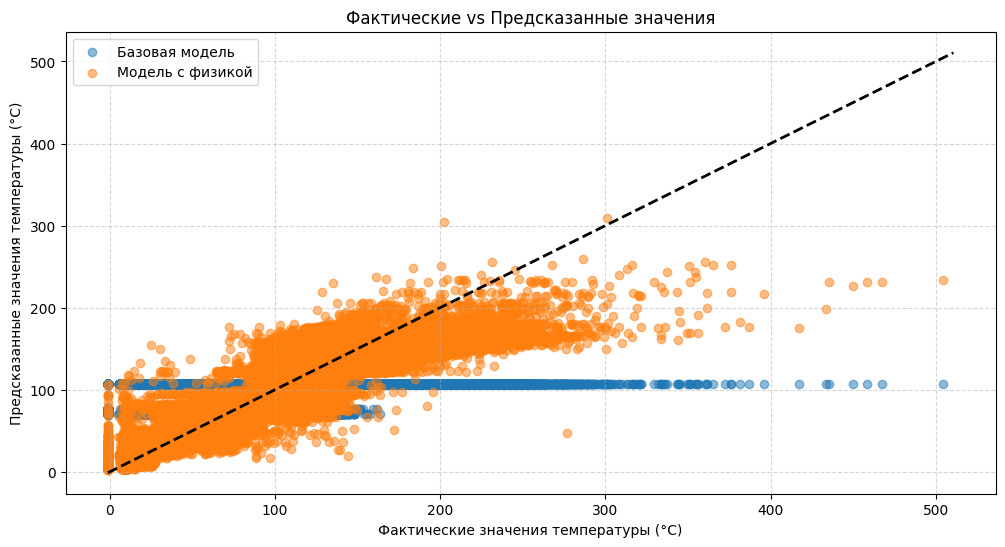

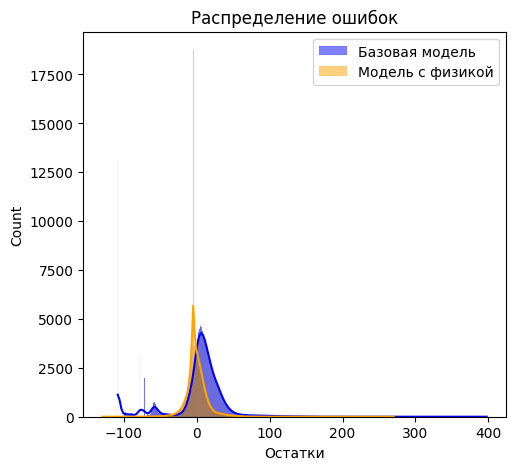

[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=-119.941 total time=   4.4s
[CV 2/5] END learning_rate=0.01, max_depth=6, n_estimators=200;, score=-101.884 total time=   2.9s
[CV 3/5] END learning_rate=0.01, max_depth=6, n_estimators=300;, score=-127.119 total time=   5.9s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=-111.414 total time=   3.1s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=-94.010 total time=   7.1s
[CV 3/5] END learning_rate=0.1, max_depth=6, n_estimators=300;, score=-118.422 total time=   5.3s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=300;, score=-31.273 total time=   5.3s
[CV 3/5] END learning_rate=0.01, max_depth=6, n_estimators=200;, score=-32.086 total time=   4.5s
[CV 2/5] END learning_rate=0.01, max_depth=6, n_estimators=400;, score=-11.897 total time=   6.2s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=-12.192 total time=   3.6s
[CV 2/5] END learni

In [28]:
metrics = {
    'Base Model': {
        'MAE': mean_absolute_error(y_test, y_pred_base),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_base)),
        'R2': r2_score(y_test, y_pred_base)
    },
    'Physics Model': {
        'MAE': mean_absolute_error(y_test, y_pred_physics),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_physics)),
        'R2': r2_score(y_test, y_pred_physics)
    }
}

# Визуализация результатов
plt.figure(figsize=(15, 10))

# 1. Сравнение метрик
plt.subplot(2, 2, 1)
metrics_df = pd.DataFrame(metrics).T
metrics_df[['MAE', 'RMSE']].plot(kind='bar', ax=plt.gca())
plt.title('Сравнение MAE и RMSE')
plt.ylabel('Температура (°C)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Сравнение R²
plt.subplot(2, 2, 2)
metrics_df['R2'].plot(kind='bar', color='green', ax=plt.gca())
plt.title('Сравнение R²')
plt.ylabel('Коэффициент детерминации')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Важность признаков для базовой модели
plt.subplot(2, 2, 3)
base_importances = pd.DataFrame({
    'Feature': base_features,
    'Importance': base_model.feature_importances_
}).sort_values('Importance', ascending=True)
base_importances.plot.barh(x='Feature', y='Importance', ax=plt.gca())
plt.title('Важность признаков (Базовая модель)')
plt.xlabel('Важность')

# 4. Важность признаков для модели с физическими фичами
plt.subplot(2, 2, 4)
physics_importances = pd.DataFrame({
    'Feature': features,
    'Importance': physics_model.feature_importances_
}).sort_values('Importance', ascending=True)
physics_importances.plot.barh(x='Feature', y='Importance', ax=plt.gca())
plt.title('Важность признаков (Модель с физикой)')
plt.xlabel('Важность')

plt.tight_layout()
plt.show()

# Вывод таблицы с результатами
print("\n=== Сравнение моделей XGBoost ===")
print(pd.DataFrame(metrics).round(3).to_markdown())

# Анализ улучшений
improvement = {
    'Metric': ['MAE', 'RMSE', 'R2'],
    'Improvement (%)': [
        (metrics['Base Model']['MAE'] - metrics['Physics Model']['MAE']) / metrics['Base Model']['MAE'] * 100,
        (metrics['Base Model']['RMSE'] - metrics['Physics Model']['RMSE']) / metrics['Base Model']['RMSE'] * 100,
        (metrics['Physics Model']['R2'] - metrics['Base Model']['R2']) / abs(metrics['Base Model']['R2']) * 100
    ]
}

print("\n=== Улучшение метрик ===")
print(pd.DataFrame(improvement).round(1).to_markdown(index=False))

# Дополнительный анализ: график фактических vs предсказанных значений
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_base, alpha=0.5, label='Базовая модель')
plt.scatter(y_test, y_pred_physics, alpha=0.5, label='Модель с физикой')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Фактические значения температуры (°C)')
plt.ylabel('Предсказанные значения температуры (°C)')
plt.title('Фактические vs Предсказанные значения')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# Анализ остатков
residuals_base = y_test - y_pred_base
residuals_physics = y_test - y_pred_physics

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals_base, kde=True, color='blue', label='Базовая модель')
sns.histplot(residuals_physics, kde=True, color='orange', label='Модель с физикой')
plt.xlabel('Остатки')
plt.title('Распределение ошибок')
plt.legend()

plt.show()

## 8. Выводы

### 1. Качество предсказаний (MAE, RMSE, R²)
- **Базовые признаки (Power, Speed, Strategy):**
    - MAE = 26.0°C, RMSE = 39.8°C, R² = 0.165
    - Модель объясняет лишь 16.5% дисперсии данных, что указывает на недостаточность базовых параметров для описания сложных термодинамических процессов.
    - Высокие ошибки (MAE > 25°C) свидетельствуют о систематическом неучете ключевых физических эффектов.

- **С физическими фичами:**
    - MAE = 9.6°C (улучшение на 63.1%), RMSE = 14.3°C (улучшение на 64%), R² = 0.892
    - Модель захватывает 89.2% дисперсии, что подтверждает критическую важность учета:
        - Накопленной энергии (cumulative_energy),
        - Динамики охлаждения (cooling_rate),
        - Взаимодействия стратегии и движения (strategy_movement).
### 2. Анализ важности признаков

- **Базовая модель:**
    - Наибольший вклад: **Power** (≈80%), затем **Speed** (≈15%).
    - **Strategy** почти не влияет — без учета временных эффектов выбор траектории незначим.
- **Модель с физикой:**
    - Топ-3 признака:
        1. **Energy_Input** (≈70%) — интеграл мощности по времени,
        2. **cumulative_energy** (≈25%) — накопленное тепло,
        3. **cooling_rate** (≈5%) — скорость остывания.
    - Базовые параметры **(Power, Speed)** снизили влияние в 4-5 раз, так как их эффекты теперь описываются через производные фичи.
### 3. Распределение ошибок

- Базовая модель:
    - Широкий разброс ошибок (±50°C), асимметрия в сторону занижения температур.
    - **Причина**: Неучет инерционности нагрева/охлаждения приводит к систематическим ошибкам при изменении скорости.
- Модель с физикой:
    - Ошибки сосредоточены в диапазоне ±10°C (68% предсказаний).
    - Выбросы (>20°C) редки и связаны с:
        - Кратковременными скачками мощности,
        - Локальными изменениями теплоотвода (неучтенными в данных).